# **Water Demand Forecasting**

## Using Deep Learing Algorithm for Time Series forecasting called LSTM(Long Short Term Memory) 

Importing Useful Libraries



In [1]:
#Basic Operations Libraries
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
#Data Anaysis Libraries
import pandas as pd
import numpy as np
#Data Visulization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#Deep Learing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Importing Dataset for analysis

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
martes = pd.read_excel('/content/drive/MyDrive/spain data (1).xlsx', sheet_name='martes_2')

# Creating Timestamps

In [4]:
# creating timestamps for dataframe to sort them further
martes['timestamps'] = ['' for i in range(len(martes))]

for i in range(len(martes)):
  martes.timestamps[i] = martes.date[i] + ' ' + str(martes.h[i])
  martes['timestamps'][i] = datetime.strptime(martes['timestamps'][i], "%y/%m/%d %H:%M:%S")

In [5]:
martes = martes.sort_values(by = 'timestamps') # sorting values by time


# Initial Data Inspection

In [6]:
martes.info()
# No null values found

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item        336 non-null    int64  
 1   demand      336 non-null    float64
 2   date        336 non-null    object 
 3   h           336 non-null    object 
 4   day         336 non-null    int64  
 5   t           336 non-null    float64
 6   wind        336 non-null    float64
 7   mlsp        336 non-null    float64
 8   rain        336 non-null    float64
 9   timestamps  336 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 28.9+ KB


In [7]:
martes.describe().T 


,count,mean,std,min,25%,50%,75%,max
item,336.0,1176.500000,678.275117,73.00,588.7500,1176.500,1764.2500,2280.00
demand,336.0,17.918988,6.770344,3.51,13.6025,16.335,21.0825,40.27
day,336.0,2.000000,0.000000,2.00,2.0000,2.000,2.0000,2.00
t,336.0,10.678571,3.955063,5.40,7.2000,10.150,12.5000,17.70
wind,336.0,9.047857,5.922365,2.22,4.4400,6.295,13.1500,22.41
mlsp,336.0,1021.678571,8.443315,1007.90,1014.8000,1021.650,1027.4000,1037.80
rain,336.0,1.728571,3.824714,0.00,0.0000,0.000,0.0000,12.70




*   range of every column is very diffrent so feature scaling would be requird for building ML model Here..... MinMaxScaler for Data Normalization is used.



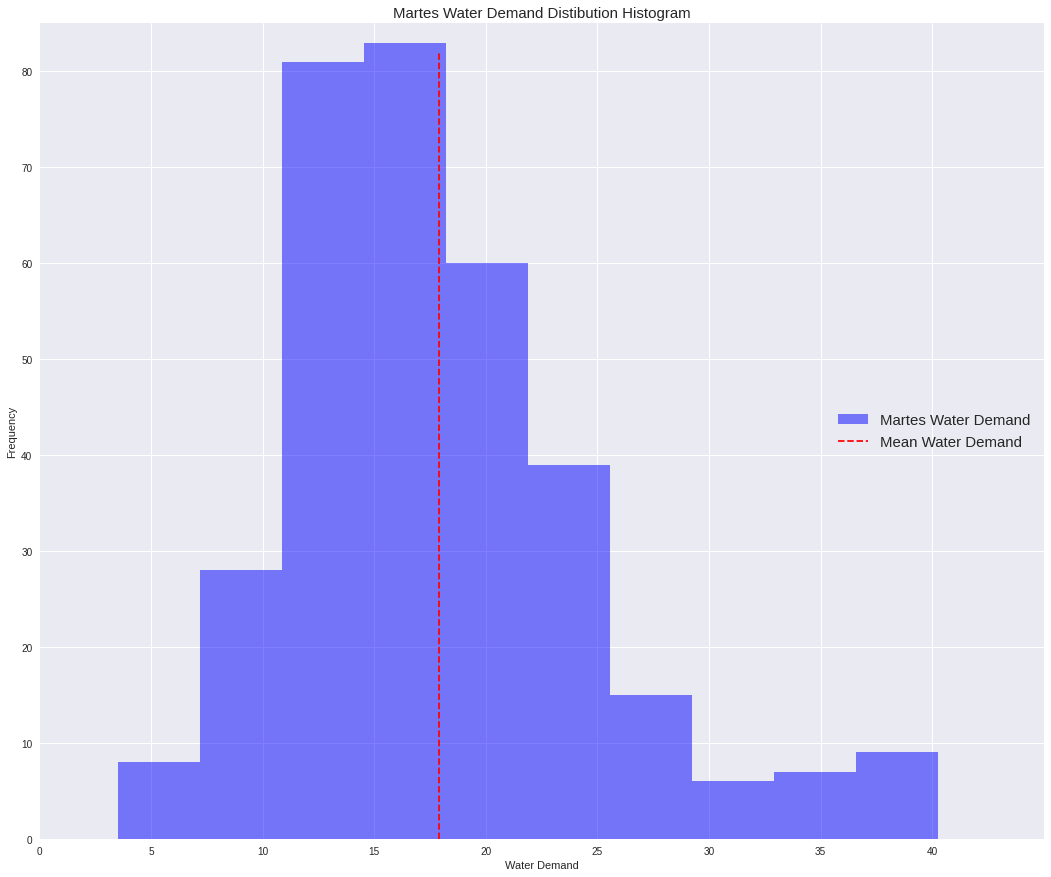

In [8]:
# Plotting Histogram for Water Demand Dataset : To observe Range, Mean, and Distribution of the data
plt.style.use("seaborn")
plt.figure(figsize = (18,15)) #change size of graph
plt.hist(martes.demand, bins = 10, label = "Martes Water Demand", alpha = 0.5, color = "blue") #Histogramm of Water Demand Distibution martes
plt.vlines(sum(martes.demand)/len(martes.demand) ,0,82, color = "red", linestyle = "--", label = "Mean Water Demand") #vertical line at NY mean
plt.title("Martes Water Demand Distibution Histogram", fontsize = 15) #set title
plt.xlabel("Water Demand") #label x-axis
plt.ylabel("Frequency") #label y-axis
plt.xticks(range(0,45,5)) #set ticks of x-axis
plt.axis((0,45,0,85)) #set range of axis
plt.grid(True) #enable/disable grid
plt.legend(loc = "center right", fontsize = 15) #include legend
plt.show()

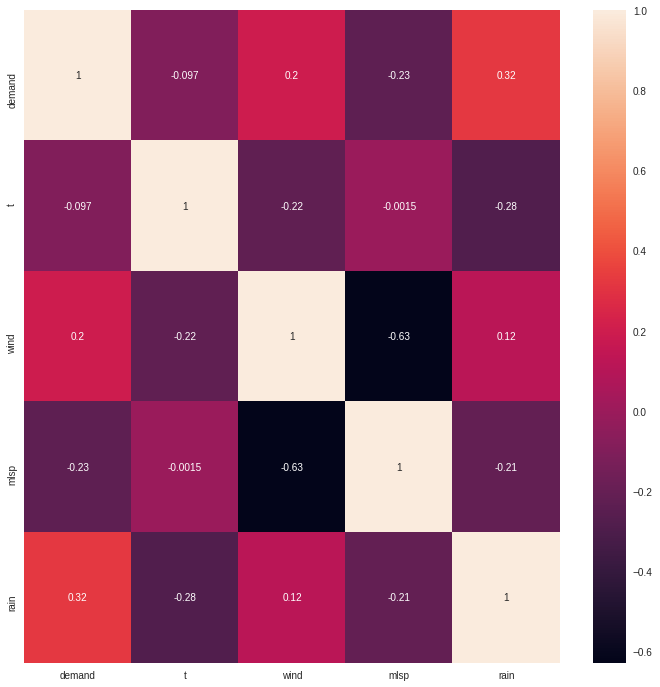

In [9]:
f, ax = plt.subplots(figsize = (12, 12))
sns.heatmap(martes.drop(['day', 'item'], axis = 1).corr(), annot = True)

# Correlation matrix is used to identify variables which have strong correlation with the Target variable(Demand) the one with least correlation is dropped to increase efficiency of the model.

In [10]:
data = martes.drop(['date', 'h','item', 'timestamps'], axis = 1)
data

,demand,day,t,wind,mlsp,rain
0,19.33,2,10.7,3.33,1037.8,2.7
1,13.83,2,10.7,3.33,1037.8,2.7
2,12.24,2,10.7,3.33,1037.8,2.7
3,11.71,2,10.7,3.33,1037.8,2.7
4,11.98,2,10.7,3.33,1037.8,2.7
...,...,...,...,...,...,...
331,14.17,2,15.9,5.00,1028.0,0.0
332,16.08,2,15.9,5.00,1028.0,0.0
333,20.84,2,15.9,5.00,1028.0,0.0
334,34.22,2,15.9,5.00,1028.0,0.0


In [11]:
data.head(5)

,demand,day,t,wind,mlsp,rain
0,19.33,2,10.7,3.33,1037.8,2.7
1,13.83,2,10.7,3.33,1037.8,2.7
2,12.24,2,10.7,3.33,1037.8,2.7
3,11.71,2,10.7,3.33,1037.8,2.7
4,11.98,2,10.7,3.33,1037.8,2.7


In [12]:
data = data.astype(float)
data

,demand,day,t,wind,mlsp,rain
0,19.33,2.0,10.7,3.33,1037.8,2.7
1,13.83,2.0,10.7,3.33,1037.8,2.7
2,12.24,2.0,10.7,3.33,1037.8,2.7
3,11.71,2.0,10.7,3.33,1037.8,2.7
4,11.98,2.0,10.7,3.33,1037.8,2.7
...,...,...,...,...,...,...
331,14.17,2.0,15.9,5.00,1028.0,0.0
332,16.08,2.0,15.9,5.00,1028.0,0.0
333,20.84,2.0,15.9,5.00,1028.0,0.0
334,34.22,2.0,15.9,5.00,1028.0,0.0


In [13]:
# Creating Target column which will have value of demand for present in the next step
demands = data['demand']
targets = list()

for i in range(len(demands)):
  if  i != 0:
    targets.append(demands[i])

targets.append(None)

In [14]:
data['Targets'] = targets

In [15]:
data

,demand,day,t,wind,mlsp,rain,Targets
0,19.33,2.0,10.7,3.33,1037.8,2.7,13.83
1,13.83,2.0,10.7,3.33,1037.8,2.7,12.24
2,12.24,2.0,10.7,3.33,1037.8,2.7,11.71
3,11.71,2.0,10.7,3.33,1037.8,2.7,11.98
4,11.98,2.0,10.7,3.33,1037.8,2.7,12.86
...,...,...,...,...,...,...,...
331,14.17,2.0,15.9,5.00,1028.0,0.0,16.08
332,16.08,2.0,15.9,5.00,1028.0,0.0,20.84
333,20.84,2.0,15.9,5.00,1028.0,0.0,34.22
334,34.22,2.0,15.9,5.00,1028.0,0.0,26.56


In [16]:
# Remove the last row as it will be a null value
data = data[:-1]
data = data.loc[:, ['demand', 'wind', 'rain','mlsp', 'Targets']]

## **Data Preprocessing**
Normalization is required as it is a Multivariate Model

In [17]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_df, columns = data.columns)

In [18]:
scaled_df.shape

(335, 5)

In [19]:
pd.DataFrame(scaled_df)

,demand,wind,rain,mlsp,Targets
0,0.430359,0.054978,0.212598,1.000000,0.280740
1,0.280740,0.054978,0.212598,1.000000,0.237486
2,0.237486,0.054978,0.212598,1.000000,0.223069
3,0.223069,0.054978,0.212598,1.000000,0.230413
4,0.230413,0.054978,0.212598,1.000000,0.254353
...,...,...,...,...,...
330,0.232046,0.137692,0.000000,0.672241,0.289989
331,0.289989,0.137692,0.000000,0.672241,0.341948
332,0.341948,0.137692,0.000000,0.672241,0.471436
333,0.471436,0.137692,0.000000,0.672241,0.835419


In [20]:
X, y = scaled_df.iloc[:, :-1], scaled_df.iloc[:, -1]

In [21]:
X.shape, y.shape

((335, 4), (335,))

In [22]:
length_of_data = len(data)
train_proportion = 0.66

train_split = int(length_of_data*(train_proportion))

Train Test split of data (2/3)rd for Training (1/3) for testing

In [23]:
X_train, X_test = np.array(X.iloc[:train_split,:]), np.array(X.iloc[ train_split:,:])
y_train, y_test = np.array(y.iloc[:train_split]), np.array(y.iloc[train_split:])

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((221, 4), (114, 4), (221,), (114,))

Visulaizing Train Test Split

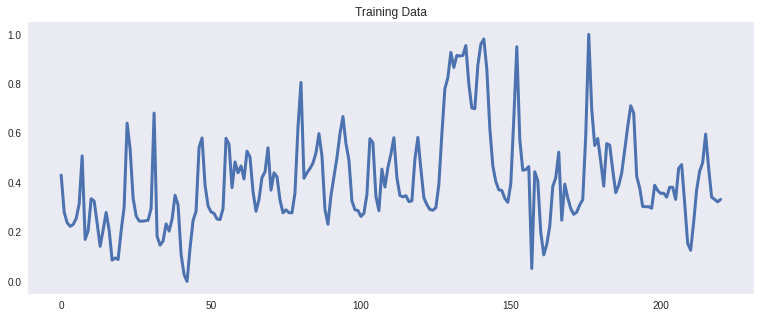

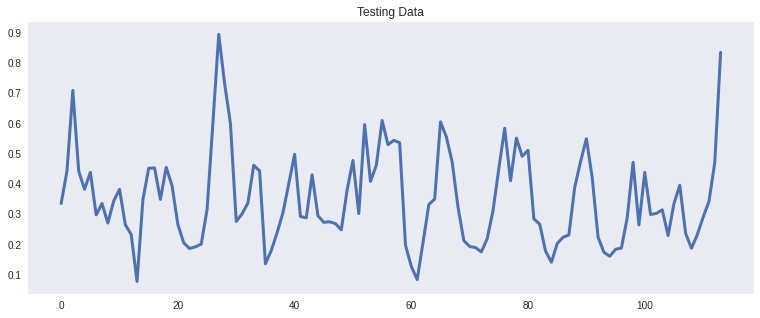

In [25]:
# Define a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()
  

show_plot(X_train[:, 0], 'Training Data')
show_plot(X_test[:,0], 'Testing Data')


In [26]:
# Data is to be formated in which it can be accepted by LSTM model which is ( [samples, time steps and features]  )
X_train = X_train.reshape(X_train.shape[0], 1,  X_train.shape[1] )
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [27]:
X_train.shape, X_test.shape

((221, 1, 4), (114, 1, 4))

## **Deep Learning Model**

### Algorithms used is **Stacked LSTM (Long- Short Term Memory) **

In [28]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.LSTM(150, return_sequences= True)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 150)            93000     
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 150)            180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151   

In [29]:
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_test, y_test) 
)


Epoch 1/50
7/7 [==============================] - 6s 246ms/step - loss: 0.2122 - val_loss: 0.1157
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.1543 - val_loss: 0.0643
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0641 - val_loss: 0.0216
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0349 - val_loss: 0.0302
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0328 - val_loss: 0.0212
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0338 - val_loss: 0.0220
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0256 - val_loss: 0.0197
Epoch 8/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0227 - val_loss: 0.0190
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0224 - val_loss: 0.0189
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 11/50
7/7 [===========

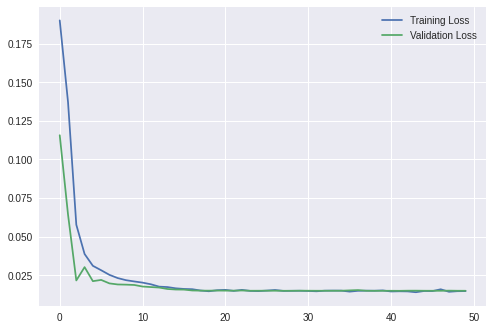

In [30]:
# MSE (Mean Squared error for Trianing and Testing Data(Here called Validation Data))
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()

In [31]:
X_train_predict = model.predict(X_train)
X_test_predict = model.predict(X_test)

In [32]:
X_train_forecast_copies = np.repeat(X_train_predict, data.shape[1], axis = -1)
X_test_forecast_copies = np.repeat(X_test_predict, data.shape[1], axis = -1)

# Inverse Scaling used to get back Orignal Values
X_train_predict = scaler.inverse_transform(X_train_forecast_copies)
X_test_predict = scaler.inverse_transform(X_test_forecast_copies)



In [33]:
X_train_predict_1 = pd.DataFrame(X_train_predict).iloc[:,0]
X_test_predict_1 = pd.DataFrame(X_test_predict).iloc[:,0]


In [34]:
X_train_predict.shape

(221, 5)

In [35]:
math.sqrt(mean_squared_error(y_train, X_train_predict_1))

18.877138964737703

In [36]:
math.sqrt(mean_squared_error(y_test, X_test_predict_1))

16.56556090987506

In [37]:
data['Predicted'] = X_train_predict_1.append(X_test_predict_1, ignore_index= True)


In [38]:
data

,demand,wind,rain,mlsp,Targets,Predicted
0,19.33,3.33,2.7,1037.8,13.83,17.497860
1,13.83,3.33,2.7,1037.8,12.24,13.794402
2,12.24,3.33,2.7,1037.8,11.71,12.763865
3,11.71,3.33,2.7,1037.8,11.98,12.424320
4,11.98,3.33,2.7,1037.8,12.86,12.597048
...,...,...,...,...,...,...
330,12.04,5.00,0.0,1028.0,14.17,13.325545
331,14.17,5.00,0.0,1028.0,16.08,14.651151
332,16.08,5.00,0.0,1028.0,20.84,15.865200
333,20.84,5.00,0.0,1028.0,34.22,18.995882


In [39]:
df_predicted = data.loc[:, ['Targets', 'Predicted']]

In [40]:
df_predicted

,Targets,Predicted
0,13.83,17.497860
1,12.24,13.794402
2,11.71,12.763865
3,11.98,12.424320
4,12.86,12.597048
...,...,...
330,14.17,13.325545
331,16.08,14.651151
332,20.84,15.865200
333,34.22,18.995882


In [41]:
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show()

In [42]:
import plotly.express as px

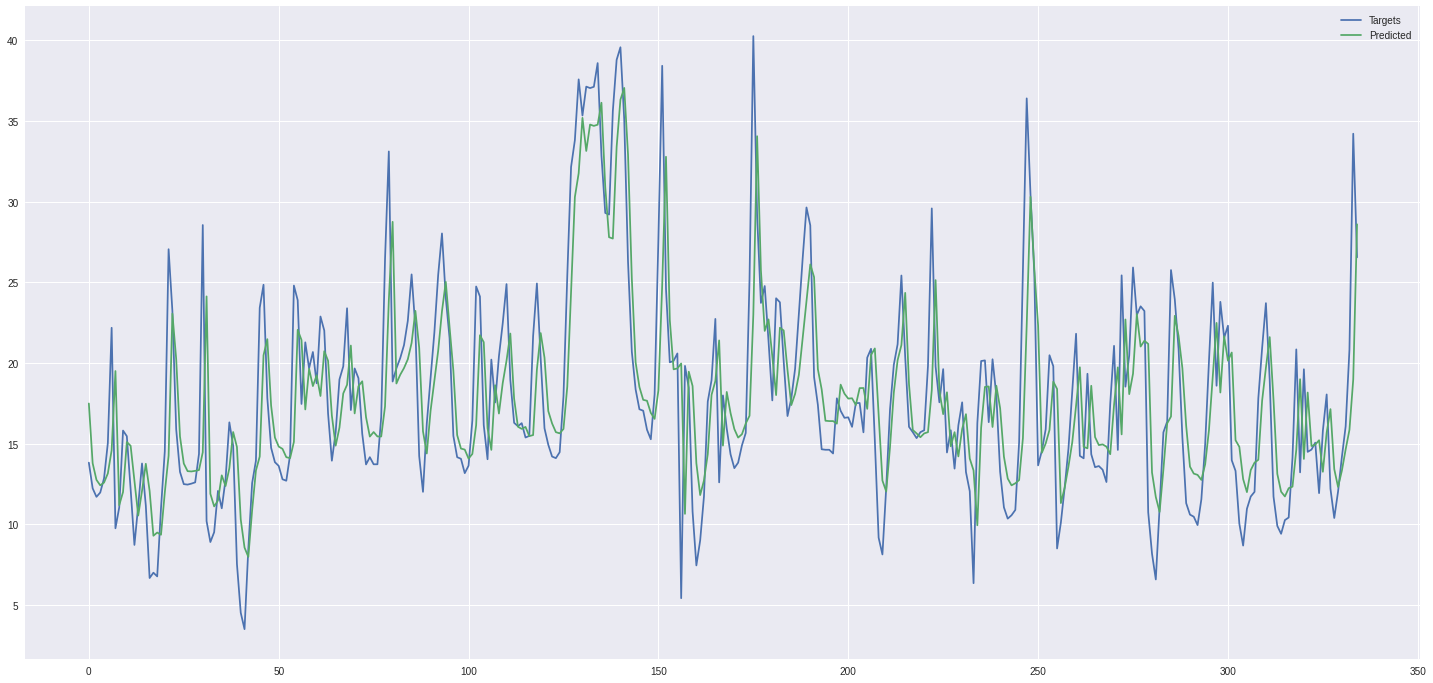

In [43]:
plt.style.use("seaborn")
plt.figure(figsize = (25,12))
plt.plot(df_predicted.index , df_predicted.loc[:, 'Targets'], label = "Targets")
plt.plot(df_predicted.index , df_predicted.loc[:, 'Predicted'], label = "Predicted")
plt.legend()
plt.show()

In [44]:
interactive_plot(df_predicted, "Final Plot")

# Observations

1. Model conservatively predicts lower demands.
2. Model under predicts higher demands.
3. There is very less diffrence between training Data Loss and testing data loss(loss: MSE) which shows model is not overfitting the data.